In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,688 cases (7 day average) as of Fri 14 May, -13.7 since Thu 13 May
75 hospitalised (7 day average) as of Sun 16 May, -2.4 since Sat 15 May
7 died (7 day average) as of Fri 14 May, -0.7 since Thu 13 May


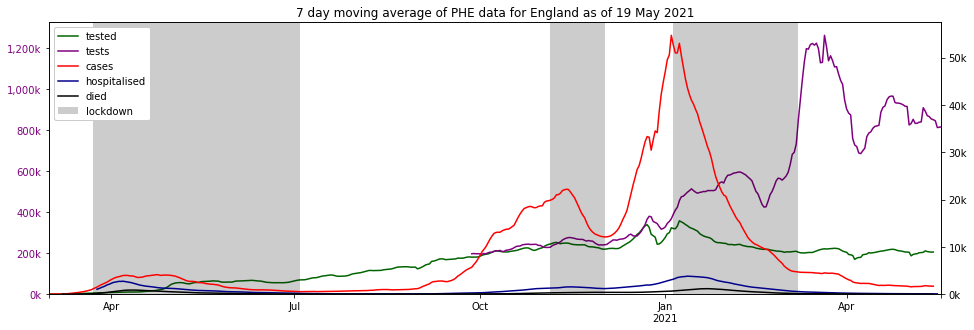

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

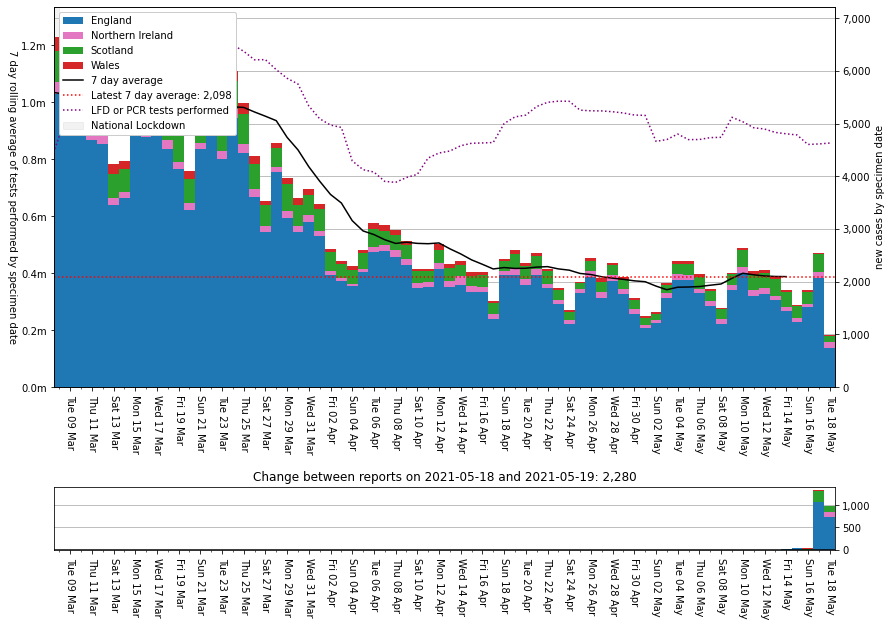

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

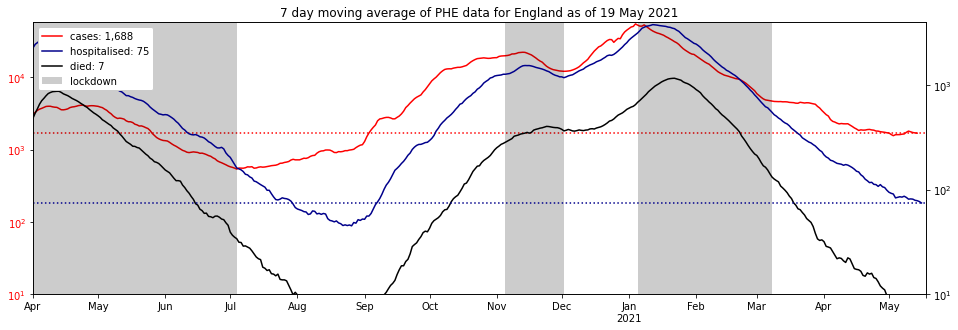

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

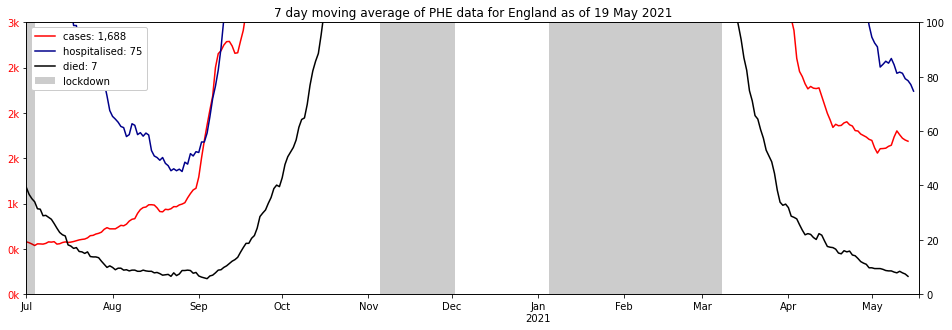

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,18 May 21,"+17,651,934","+30,884,041","+17,651,934","+269,283","+154,621","+269,283"
Northern Ireland,18 May 21,"+575,059","+1,004,070","+575,059","+7,942","+3,142","+7,942"
Scotland,18 May 21,"+1,704,388","+3,051,383","+1,704,388","+34,919","+6,231","+34,919"
Wales,18 May 21,"+939,072","+2,046,011","+939,072","+11,857","+10,106","+11,857"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,17651934.0,30884041.0,13232107.0,56286961,31.360609,23.508299,45.131092
1,Northern Ireland,N92000002,575059.0,1004070.0,429011.0,1893667,30.367483,22.655039,46.977478
2,Scotland,S92000003,1704388.0,3051383.0,1346995.0,5463300,31.197042,24.655337,44.147621
3,Wales,W92000004,939072.0,2046011.0,1106939.0,3152879,29.784587,35.108832,35.106580


'partial: 36,985,505 (55.4%), full: 20,870,453'

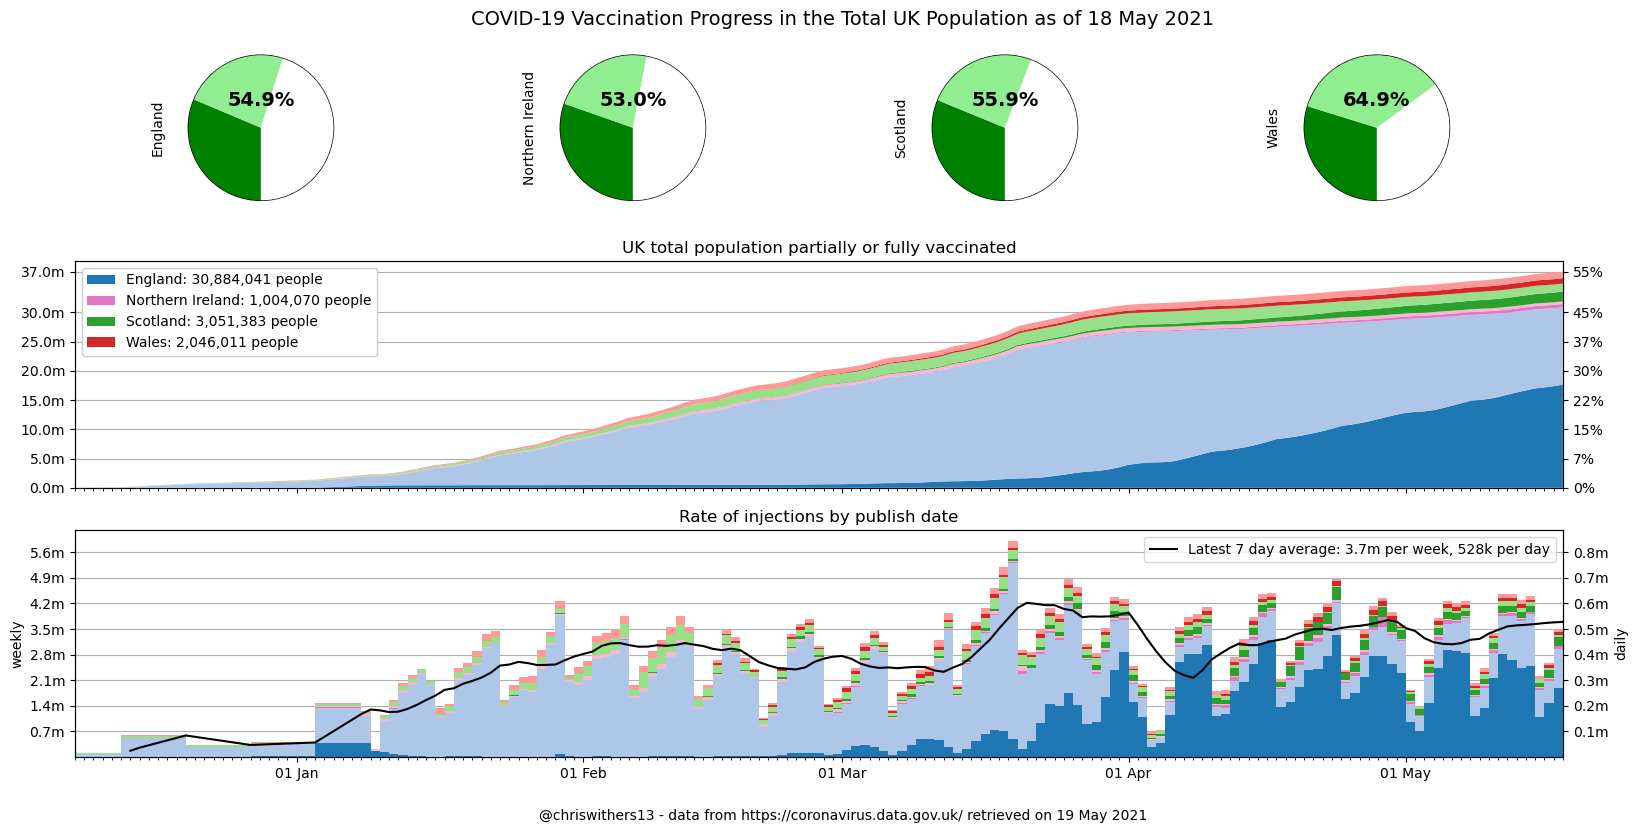

In [8]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

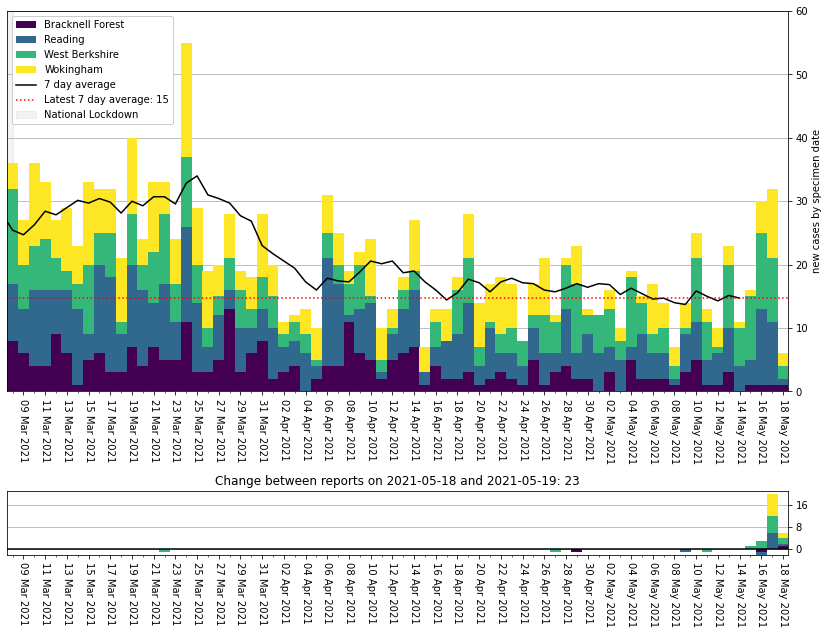

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], ylim=60)

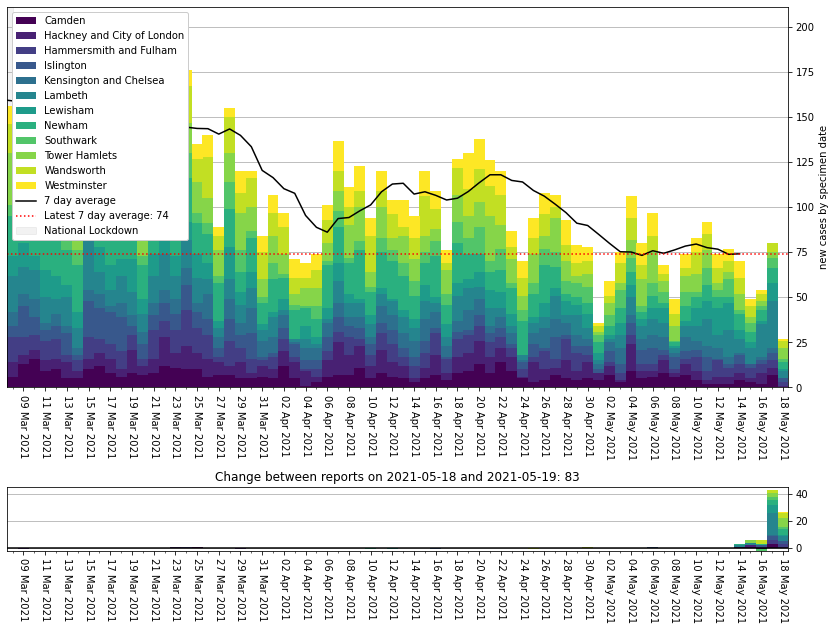

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1])

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,312.641280,899.0,2021-05-18
E06000008,Blackburn with Darwen,173.017315,259.0,2021-05-18
E06000055,Bedford,120.605683,209.0,2021-05-18
S12000011,East Renfrewshire,103.632367,99.0,2021-05-18
S12000049,Glasgow City,100.612838,637.0,2021-05-18
N09000005,Derry City and Strabane,87.914122,133.0,2021-05-18
E08000034,Kirklees,79.356598,349.0,2021-05-18
S12000005,Clackmannanshire,58.207218,30.0,2021-05-18
N09000009,Mid Ulster,53.861898,80.0,2021-05-18


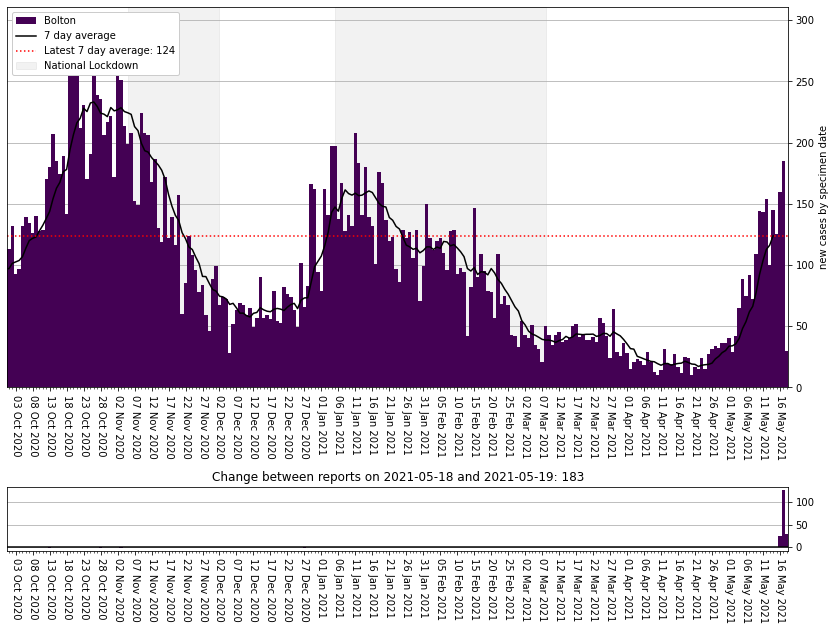

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,312.641280,899.0,2021-05-18
S12000049,Glasgow City,100.612838,637.0,2021-05-18
E08000034,Kirklees,79.356598,349.0,2021-05-18
E08000035,Leeds,35.176684,279.0,2021-05-18
E06000008,Blackburn with Darwen,173.017315,259.0,2021-05-18
E08000003,Manchester,38.888829,215.0,2021-05-18
E08000032,Bradford,39.275551,212.0,2021-05-18
E06000055,Bedford,120.605683,209.0,2021-05-18
E08000019,Sheffield,30.093032,176.0,2021-05-18


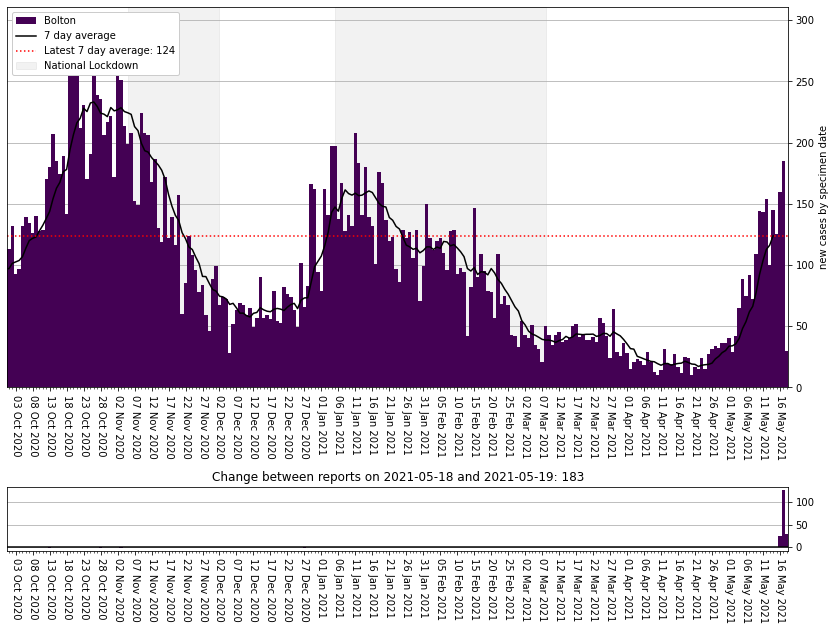

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

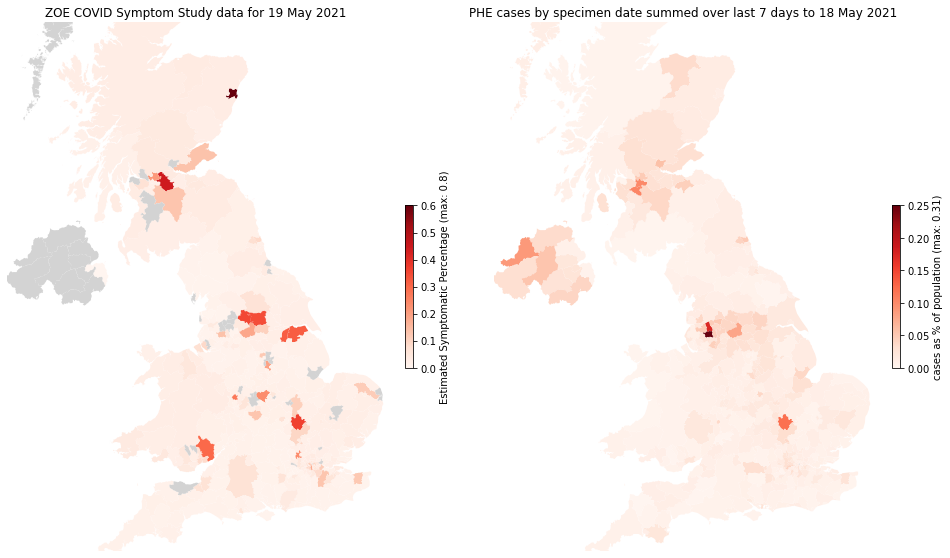

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...